<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/bert_ita_multiclass_doppio_val_hyp_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


In [4]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [5]:
df_dev = load_dataset("csv", data_files="dataset/subtaskB_clean_dev_cased.csv")#, column_names=['text', 'label'])#, features=features)
df_test = load_dataset("csv", data_files="dataset/subtaskB_clean_test_cased.csv")#, column_names=['text', 'label'])#, features=features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
df_dev = df_dev.rename_column("comment_text", "text")
df_dev = df_dev.rename_column("topic", "label")
df_test = df_test.rename_column("comment_text", "text")

In [7]:
class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

In [8]:
label = ClassLabel(num_classes=4, names=class_names)
#features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=4, names=class_names)})

In [9]:
df_dev = df_dev.cast_column("label", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [10]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 810
    })
})

In [11]:
np.unique(df_dev['train']['label'], return_counts=True)

(array([0, 1, 2, 3]), array([435, 242,  57,  76]))

# Data partioning

In [12]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 243
    })
})

In [13]:
df_train = train_val["train"]
df_val_ = train_val["test"]

In [14]:
df_val_ = df_val_.train_test_split(test_size=0.3, seed=0)

In [15]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 170
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 73
    })
})

In [16]:
df_val = df_val_["train"]
df_val2 = df_val_["test"]

In [17]:
df_train

Dataset({
    features: ['text', 'label'],
    num_rows: 567
})

In [18]:
df_val

Dataset({
    features: ['text', 'label'],
    num_rows: 170
})

In [19]:
df_val2

Dataset({
    features: ['text', 'label'],
    num_rows: 73
})

In [20]:
np.unique(df_val['label'], return_counts=True)

(array([0, 1, 2, 3]), array([89, 50, 14, 17]))

# Model loading

In [21]:
nome = 'bert-base-italian-cased'
model_name = 'dbmdz/bert-base-italian-cased'

In [22]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [24]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [25]:
tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

In [26]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 567
})

In [27]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [28]:
label2id = {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
}

In [29]:
id2label = {
    "0": 'Covid',
    "1": 'QAnon',
    "2": 'Russia',
    "3": 'Terra Piatta'
}

In [30]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [31]:
def hyperparameter_search(model_name=model_name, optim='adamw_hf', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=13,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name, num_labels=len(label2id))
    config.id2label = id2label
    config.label2id = label2id
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    return config, training_args, model

In [33]:
dropout = 0.1
learning_rate = 0.00005

config, training_args, model = hyperparameter_search(dropout=dropout, learning_rate=learning_rate)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
model.config

BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Covid",
    "1": "QAnon",
    "2": "Russia",
    "3": "Terra Piatta"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

In [ ]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


# Evaluation

In [ ]:
log_history = trainer.state.log_history

In [ ]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

In [ ]:
df.to_html(f'subtaskB/loss_{nome}.html')

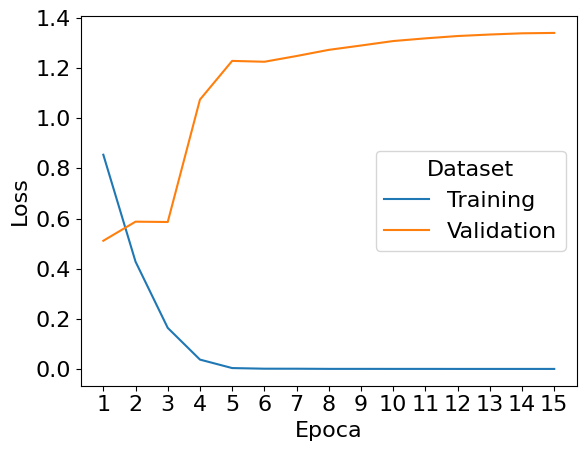

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'subtaskB/loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_predictions_1 = trainer.predict(tokenized_val)
output_predictions_2 = trainer.predict(tokenized_val2)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
y_val_1 = tokenized_val["label"]
y_val_2 = tokenized_val2["label"]
y_val_pred_1 = np.argmax(output_predictions_1.predictions, axis=1)
y_val_pred_2 = np.argmax(output_predictions_2.predictions, axis=1)

report = classification_report(y_val_1, y_val_pred_1, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Covid       0.91      0.84      0.88        89
       Qanon       0.75      0.80      0.78        50
      Russia       0.75      0.86      0.80        14
Terra Piatta       0.84      0.94      0.89        17

    accuracy                           0.84       170
   macro avg       0.82      0.86      0.84       170
weighted avg       0.85      0.84      0.84       170



In [ ]:
report = classification_report(y_val_2, y_val_pred_2, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Covid       0.95      0.90      0.92        41
       Qanon       0.86      0.78      0.82        23
      Russia       0.60      1.00      0.75         3
Terra Piatta       0.75      1.00      0.86         6

    accuracy                           0.88        73
   macro avg       0.79      0.92      0.84        73
weighted avg       0.89      0.88      0.88        73



In [ ]:
with open(f"subtaskB/class_report_{nome}_val2.html", "w") as file:
    file.write(report)

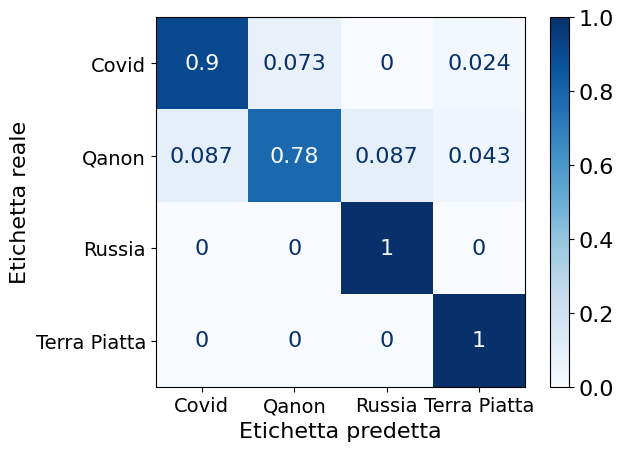

In [ ]:
plt.rcParams.update({'font.size': 16})
ConfusionMatrixDisplay.from_predictions(y_val_2, y_val_pred_2, cmap='Blues', normalize='true', display_labels=class_names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'subtaskB/conf_matrix_{nome}_val2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model_directory = 'bert-base-italian-cased-finetuned/checkpoint-71'

model = AutoModelForSequenceClassification.from_pretrained(model_directory)
trainer = Trainer(model=model)
output_prediction_loss_1 = trainer.predict(tokenized_val)
output_prediction_loss_2 = trainer.predict(tokenized_val2)

In [ ]:
y_val_1 = tokenized_val["label"]
y_val_pred_1 = np.argmax(output_prediction_loss_1.predictions, axis=1)

In [ ]:
report = classification_report(y_val_1, y_val_pred_1, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Covid       0.87      0.87      0.87        89
       Qanon       0.75      0.60      0.67        50
      Russia       0.57      0.86      0.69        14
Terra Piatta       0.85      1.00      0.92        17

    accuracy                           0.80       170
   macro avg       0.76      0.83      0.78       170
weighted avg       0.81      0.80      0.80       170



In [ ]:
y_val_2 = tokenized_val2["label"]
y_val_pred_2 = np.argmax(output_prediction_loss_2.predictions, axis=1)

report = classification_report(y_val_2, y_val_pred_2, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Covid       0.88      0.85      0.86        41
       Qanon       0.67      0.52      0.59        23
      Russia       0.43      1.00      0.60         3
Terra Piatta       0.75      1.00      0.86         6

    accuracy                           0.77        73
   macro avg       0.68      0.84      0.73        73
weighted avg       0.78      0.77      0.76        73

